In [1]:
# %pip install pandas networkx numpy os torch torch_geometric node2vec scipy matplotlib

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import os.path as osp
# import torch
from torch_geometric.datasets import Planetoid
from node2vec import Node2Vec

from scipy.spatial.distance import pdist
from scipy import linalg

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import SpectralClustering

## Data Import

In [3]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset)  # dowload or load the Cora dataset
data = dataset[0]

In [4]:
data.node_attrs

<bound method BaseData.node_attrs of Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])>

In [5]:
labels = data.y.tolist()

In [6]:
set(labels)

{0, 1, 2, 3, 4, 5, 6}

## Generate Networkx Graph

In [7]:
# Create a NetworkX graph from the PyTorch Geometric dataset
G = nx.Graph()
for i, j in data.edge_index.t().tolist():
    G.add_edge(i, j)

In [8]:
# Get the adjacency matrix
adjacency_matrix = nx.to_numpy_matrix(G)

# Convert the adjacency matrix to a NumPy array
adjacency_matrix = np.array(adjacency_matrix)

In [9]:
adjacency_matrix

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Eigen Decomposition

In [10]:
# Calculate degree matrix

dimension = len(adjacency_matrix)

degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)

In [11]:
degree_matrix

array([[3., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [12]:
# Normalized laplacian matrix
d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
laplacian_matrix = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)

# Random walk Laplacian matrix
# d_inverse = linalg.fractional_matrix_power(degree_matrix, -1)
# laplacian_matrix = np.matmul(d_inverse, adjacency_matrix)

In [13]:
laplacian_matrix

array([[0.        , 0.33333333, 0.28867513, ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28867513, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [14]:
# Calculating eigenvalues and eigenvectors
e, v = np.linalg.eigh(laplacian_matrix)

In [15]:
# Eigenvalues
e

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [16]:
# Eigenvectors
v

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.92422518e-18, -4.16658393e-19, -1.74682967e-20, ...,
        -4.54143753e-19, -3.12572452e-19,  1.04755407e-17],
       [-2.05236896e-17, -6.54653435e-18,  5.57174181e-18, ...,
        -3.54356631e-19, -4.36775085e-18,  1.17785657e-17],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.22541544e-18, -2.03372223e-17,  1.04525474e-17, ...,
        -9.73068803e-18,  1.77137750e-18,  3.61847975e-17],
       [ 6.53173569e-18,  4.56708304e-18,  2.83166168e-18, ...,
        -7.62131129e-20, -1.46072949e-17, -3.70852200e-18]])

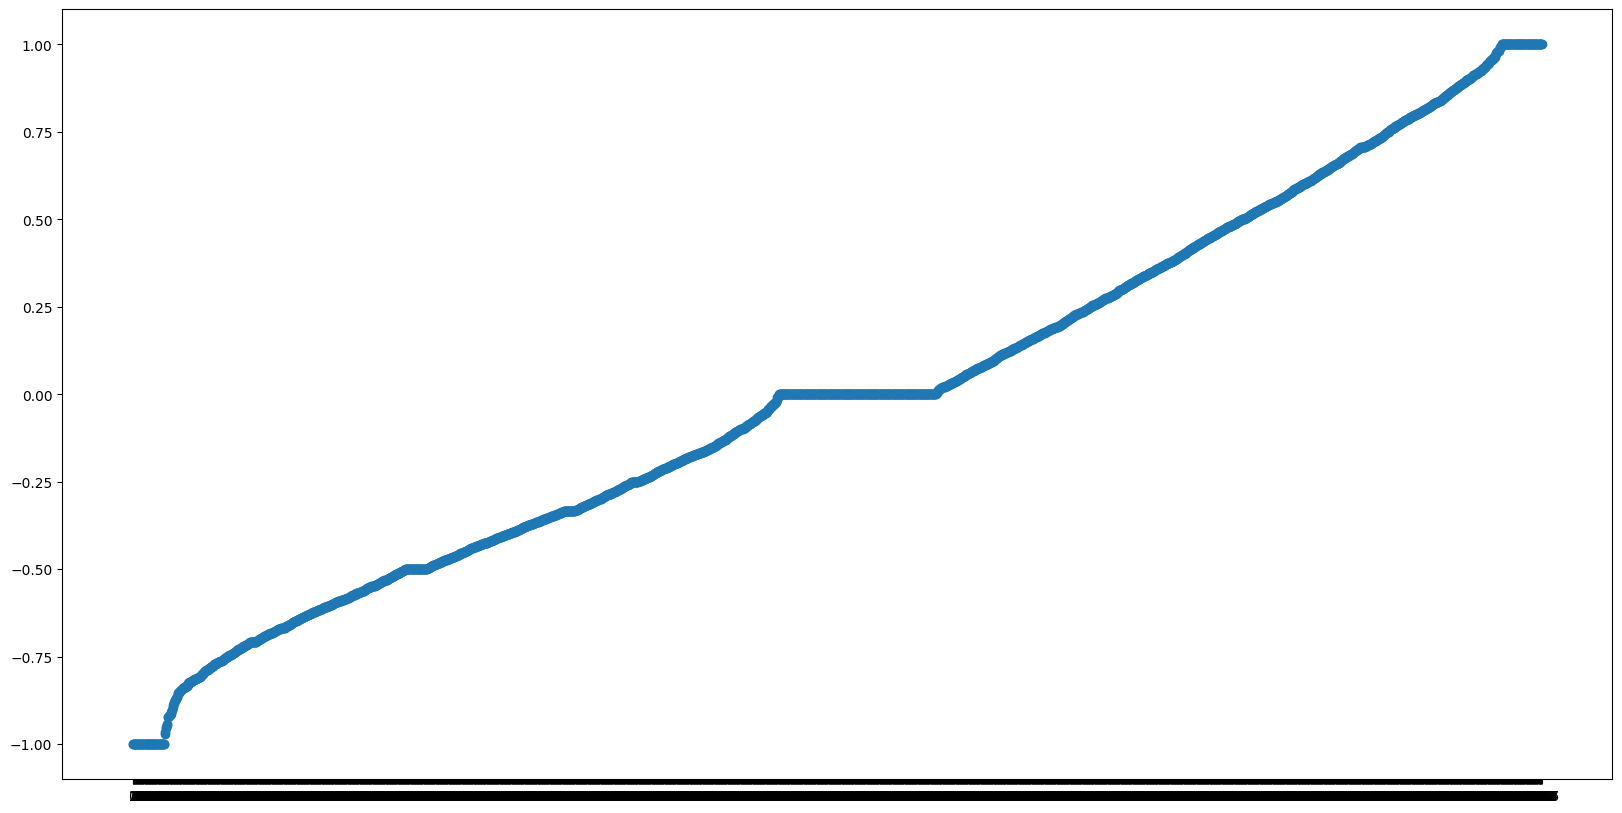

In [17]:
# Plotting the eigenvalues
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(range(len(e)), e);
plt.xticks(range(0,len(e)));

In [18]:
# Gaps in eigenvalues
gaps = np.diff(e)
eigen_gap_df = pd.DataFrame({'Index': range(len(e) - 1), 'Gap': gaps})
eigen_gap_df.sort_values(by='Gap', ascending=False, inplace=True)

In [19]:
eigen_gap_df

,Index,Gap
61,61,0.029234
67,67,0.019980
63,63,0.012755
86,86,0.009814
2626,2626,0.008880
...,...,...
46,46,0.000000
45,45,0.000000
44,44,0.000000
42,42,0.000000


In [20]:
eigen_gap_df[eigen_gap_df['Index'] < 10]

,Index,Gap
2,2,4.440892e-16
9,9,2.220446e-16
3,3,2.220446e-16
7,7,0.000000e+00
6,6,0.000000e+00
5,5,0.000000e+00
4,4,0.000000e+00
8,8,0.000000e+00
1,1,0.000000e+00
0,0,0.000000e+00


In [21]:
# Eigen features for k
k = 7
X = v[:, -1*k:]
# Y = X / row_sums[:, np.newaxis]

## Clustering

In [22]:
cluster_df = pd.DataFrame(X)
cluster_df

,0,1,2,3,4,5,6
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,-2.133764e-33,1.417362e-17,6.533112e-34,9.144130e-18,-4.541438e-19,-3.125725e-19,1.047554e-17
2,3.535851e-33,2.310745e-17,1.232811e-33,6.517973e-18,-3.543566e-19,-4.367751e-18,1.177857e-17
3,-9.502600e-34,-3.418953e-17,-1.723524e-33,-1.556441e-17,7.607631e-19,4.098308e-18,-2.067043e-17
4,6.334050e-33,-5.628194e-18,5.593034e-34,3.575664e-18,-1.562567e-18,2.470737e-18,-4.925657e-17
...,...,...,...,...,...,...,...
2703,9.858354e-33,-3.472412e-18,2.016509e-32,8.914852e-17,-8.971336e-18,-1.104160e-18,1.626136e-16
2704,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2705,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2706,-2.208751e-18,-2.666571e-17,3.017150e-18,-5.028665e-17,-9.730688e-18,1.771378e-18,3.618480e-17


In [28]:
clustering = KMeans(n_clusters = 7)
clustering.fit(cluster_df)

cluster_labels = clustering.labels_
print(silhouette_score(cluster_df, cluster_labels),adjusted_rand_score(labels, cluster_labels))

0.972430808217798 -0.00020896767058245847


C:\Users\mondal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
